In [141]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [142]:
def walkit(k1=1.0,k2=1.0,kap=1.0,v=1.0,dt=1e-2,tmax=10,theta0=0.5,theta1=0.5):
    """
    kap is the trapping rate from rest
    k1 is the inverse mean resting time
    k2 is the inverse mean moving time
    v is the velocity
    tmax is the maximum time to walk
    theta0 is the probability of starting at rest
    theta1 is the probability of starting in motion
    """
    s = int(np.random.random() > theta0) # initial state
    N = int(tmax/dt) # number of iterations
    X = np.empty(N+1) # displacement array
    R = np.random.random(size=(N,2)) # uniform randoms
    t = 0.0 # initial time
    x = 0.0
    X[0]=x
    for n,(r1,r2) in enumerate(R):
        t += dt
        if s==0:
            val1 = 1 - np.exp(-k1*dt) > r1 # probability that transition to motion occurs
            val2 = 1 - np.exp(-kap*dt) > r2  # probability that trapping occurs 
            if val1 and not val2:
                s = 1  # transitions to state 1
            elif val2:
                s=-1 # traps
                print('trapped at {}'.format(t))
                X[n:]=x
                break
        elif s==1:
            x = x + v*dt # displacement
            if np.exp(-k2*dt)<r1:
                s = 0   # transitions to state 0
        X[n+1] = x
    return X[:-1]
def ens(Nens = 100, k1=1.0,k2=1.0,kap=1.0,v=1.0,dt=1e-2,tmax=10,theta0=0.5,theta1=0.5):
    N = int(tmax/dt) # number of iterations
    X = np.empty((Nens,N))
    for n in range(Nens):
        x = walkit(k1=k1,k2=k2,kap=kap,v=v,dt=dt,tmax=tmax,theta0=theta0,theta1=theta1)
        X[n,:]=x
        #print('iteration {} complete'.format(n+1),end="\n",flush=True)
    return X

In [37]:
k1 = 1
k2 = 0.1
kap = 1e-3
v = 0.5
Tsupersmall = np.arange(0,10,1e-4)
Xsupersmall = ens(300,dt=1e-4,tmax=10,k1=k1,k2=k2,kap=kap,theta0=0,theta1=1.0,v=0.5)
Tsmall = np.arange(0,100,1e-2)
Xsmall = ens(300,dt=1e-2,tmax=100,k1=k1,k2=k2,kap=kap,theta0=0,theta1=1.0,v=0.5)
Tlarge = np.arange(0,1e6,1)
Xlarge = ens(300,dt=1,tmax=1e6,k1=k1,k2=k2,kap=kap,theta0=0,theta1=1.0,v=0.5)

trapped at 48.28999999999896
trapped at 61.39999999999635
trapped at 15.629999999999711
trapped at 30007.0
trapped at 3043.0
trapped at 14241.0
trapped at 2091.0
trapped at 30919.0
trapped at 13714.0
trapped at 16027.0
trapped at 8582.0
trapped at 5350.0
trapped at 5554.0
trapped at 1674.0
trapped at 3489.0
trapped at 10535.0
trapped at 99.0
trapped at 5642.0
trapped at 166.0
trapped at 3822.0
trapped at 13507.0
trapped at 3453.0
trapped at 3379.0
trapped at 3430.0
trapped at 1395.0
trapped at 1375.0
trapped at 4689.0
trapped at 1853.0
trapped at 6587.0
trapped at 6146.0
trapped at 109.0
trapped at 11690.0
trapped at 8723.0
trapped at 5377.0
trapped at 8065.0
trapped at 3485.0
trapped at 1014.0
trapped at 1465.0
trapped at 4053.0
trapped at 2154.0
trapped at 6465.0
trapped at 6848.0
trapped at 3090.0
trapped at 9701.0
trapped at 32455.0
trapped at 3319.0
trapped at 18808.0
trapped at 27091.0
trapped at 12398.0
trapped at 5173.0
trapped at 23580.0
trapped at 6466.0
trapped at 5370.0
tra

In [143]:
def cumulants(t,flag,k1,k2,kap,v):
    """ this provides the expressions """
    kp = k1 + k2
    exp=np.exp
    sqrt = np.sqrt
    a = (kap+kp)/2.0
    b = sqrt(a**2-kap*k2)
    A1 = v/(2*b)*(1+(kap+k1)/(b-a))
    B1 = v/(2*b)*(-1+(kap+k1)/(a+b))
    C1 = -v/(2*b)*(1/(b-a)+1/(a+b))*(kap+k1)
    def A2(t):
        out = b+(b-a)*(b*t-1)+2*(kap+k1)*(b*t-1)
        out += (kap+k1)**2/(a-b)**2*(-a*b*t+a+b*(b*t-2))
        return v**2/(2*b**3)*out
    def B2(t):
        out = b-(a+b)*(b*t+1)+2*(kap+k1)*(b*t+1) # sign is correct here.
        out += -(kap+k1)**2/(a+b)**2*(b*t*(a+b)+a+2*b)
        return v**2/(2*b**3)*out
    C2 = v**2/(2*b**3)*(kap+k1)**2*((a+2*b)/(a+b)**2 + (-a+2*b)/(a-b)**2)
    if flag==1: # compute the mean
        return A1*exp((b-a)*t)+B1*exp(-(a+b)*t)+C1
    elif flag==2: # compute the var
        out = (A2(t)-2*A1*C1-A1**2*exp((b-a)*t))*exp((b-a)*t)
        out += (B2(t)-2*B1*C1-B1**2*exp(-(a+b)*t))*exp(-(a+b)*t)
        out += C2 - C1**2 - 2*A1*B1*exp(-2*a*t)
        return out

In [43]:
k1 = 1
k2 = 0.1
kap = 1e-3
v = 0.5
Tsupersmall = np.arange(0,10,1e-4)
Xsupersmall = ens(300,dt=1e-4,tmax=10,k1=k1,k2=k2,kap=kap,theta0=1,theta1=0,v=0.5)
Tsmall = np.arange(0,100,1e-2)
Xsmall = ens(300,dt=1e-2,tmax=100,k1=k1,k2=k2,kap=kap,theta0=1,theta1=0,v=0.5)
Tlarge = np.arange(0,1e6,1)
Xlarge = ens(300,dt=1,tmax=1e6,k1=k1,k2=k2,kap=kap,theta0=1,theta1=0,v=0.5)

trapped at 94.95000000001167
trapped at 4838.0
trapped at 30263.0
trapped at 9830.0
trapped at 195.0
trapped at 4075.0
trapped at 15666.0
trapped at 894.0
trapped at 3628.0
trapped at 10988.0
trapped at 4462.0
trapped at 17862.0
trapped at 11160.0
trapped at 4246.0
trapped at 12874.0
trapped at 3924.0
trapped at 8751.0
trapped at 5218.0
trapped at 3981.0
trapped at 9735.0
trapped at 2342.0
trapped at 2334.0
trapped at 2911.0
trapped at 533.0
trapped at 3875.0
trapped at 8962.0
trapped at 7896.0
trapped at 829.0
trapped at 15346.0
trapped at 1901.0
trapped at 373.0
trapped at 7679.0
trapped at 8733.0
trapped at 3350.0
trapped at 19908.0
trapped at 24173.0
trapped at 17974.0
trapped at 1833.0
trapped at 1134.0
trapped at 11045.0
trapped at 3380.0
trapped at 10818.0
trapped at 11728.0
trapped at 434.0
trapped at 11425.0
trapped at 3125.0
trapped at 15921.0
trapped at 8178.0
trapped at 24238.0
trapped at 3526.0
trapped at 6746.0
trapped at 2476.0
trapped at 9603.0
trapped at 3144.0
trapped

(1e-06, 1000000000.0)

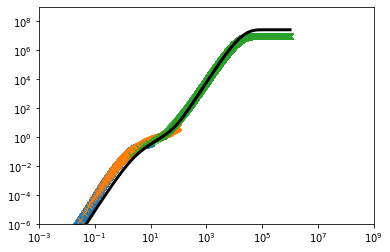

In [45]:
plt.loglog(Tsupersmall,Xsupersmall.var(0),'x')
plt.loglog(Tsmall,Xsmall.var(0),'x')
plt.loglog(Tlarge,Xlarge.var(0),'x')
#plt.loglog(Tsuperlarge,Xsuperlarge.var(0),'x',color='pink')
t = np.geomspace(1e-2,Tlarge.max(),1000)
plt.loglog(t,cumulants(t,2,k1,k2,kap,v),color='black',lw=3)
plt.xlim(1e-3,1e9)
plt.ylim(1e-6,1e9)

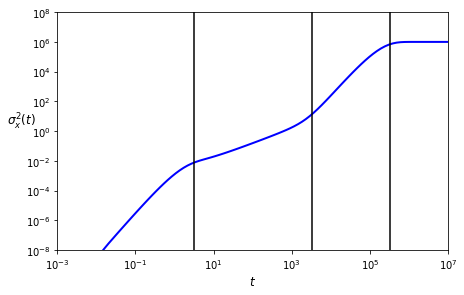

In [261]:
tm = 1
tr = 10
tt = 100000
k1 = 1/tr
k2 = 1/tm
kap = 1/tt
v=0.1
t = np.geomspace(1e-3,1e7,100)
plt.loglog(t,cumulants(t,2,k1,k2,kap,v),color='blue',lw=2)#,marker='x',linestyle='None')
plt.ylim(1e-8,1e8)
plt.xlim(1e-3,1e7)

# k1/(k1+k2) is fraction of time spent in motion
# k2/(k1+k2) is fraction of time spent at rest

# crossover from 1st ballistic regime
time1 = 1/np.sqrt(k1*k2)
plt.axvline(time1,color='black')

# crossover zone from 2nd ballistic regime
tau1 = 1/kap
tau2 = 1/(k1*kap/(k1+k2))
time3 = np.sqrt(tau1*tau2)
plt.axvline(time3,color='black')
plt.xlabel(r'$t$',fontsize=12)
plt.ylabel(r'$\sigma_x^2(t)$',rotation=0,fontsize=12)

# crossover zone into 2nd ballistic regime
#plt.axvline(np.sqrt(1/kap/k2))
#plt.axvline(np.sqrt(1/kap*1/(k1*kap/(k1+k2))))

# mix the lower two times... 
time2 = (1/k1*tau2)**(1/2)
plt.axvline(time2,color='black')

fig = plt.gcf()
fig.set_figheight(7/1.6)
fig.set_figwidth(7)
fig.savefig('../grl/figures/diffusion.png', bbox_inches='tight',dpi=600)

In [ ]:
fig.set_figheight()

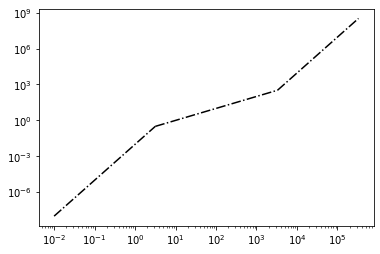

In [250]:

val = 1e-2
# local range
t0 = np.geomspace(1e-2,time1,100)
plt.loglog(t0,t0**3*val,linestyle='-.',color='black')
val = (t0**3*val).max()
# intermediate range
t1 = np.geomspace(time1,time2,100)
plt.loglog(t1,t1/t1.min()*val,linestyle='-.',color='black')
val = (t1/t1.min()*val).max()
# global range
t2 = np.geomspace(time2,time3,100)
plt.loglog(t2,t2**3/(t2**3).min()*val,linestyle='-.',color='black')
# geomorphic range

In [234]:
val

0.316227766016838

In [223]:
1/k2

1.0